# Equivalent Inertia of Renewable Penetrated Systems

In this demo, we will discuss the equivalent inertia calculation of renewable penetrated systems.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import scienceplots

import andes

andes.__version__

'1.9.3'

In [2]:
%matplotlib inline

In [3]:
andes.config_logger(stream_level=30)

## Case Preparation

case0: base case, all five generators are synchronous generators (SG)

case1: replace one SG with a grid forming inverter (GFM)

case2: replace one SG with a grid following inverter (GFL)

case3: replace one SG with a "negative" load

case4: replace one SG with a GFL, also increase the GFL's p0

In [4]:
case_file = andes.get_case('ieee14/ieee14_full.xlsx')

# case0: base case
s0 = andes.load(case_file,
                setup=False, no_output=True, default_config=False)

syg5 = 'GENROU_5'
stg5 = s0.GENROU.get(src='gen', attr='v', idx=syg5)
bus5 = s0.GENROU.get(src='bus', attr='v', idx=syg5)
Sn5 = s0.GENROU.get(src='Sn', attr='v', idx=syg5)
p05 = s0.StaticGen.get(src='p0', attr='v', idx=stg5)
tg5 = s0.TGOV1.find_idx(keys='syn', values=[syg5])[0]
R5 = s0.TGOV1.get(src='R', attr='v', idx=tg5)

# case1: note that `kw` is equivalent to `1/R`, and here we turn it off
s1 = andes.load(case_file,
                setup=False, no_output=True, default_config=False)
s1.add(model='REGCV1',
       param_dict=dict(bus=bus5, gen=stg5, Sn=Sn5,
                       M=s1.GENROU.get(src='M', attr='v', idx=syg5),
                       D=s1.GENROU.get(src='D', attr='v', idx=syg5),
                       kw=0, kv=0))
s1.SynGen.alter(src='u', idx=syg5, value=0)

# case2
s2 = andes.load(case_file,
                setup=False, no_output=True, default_config=False)
s2.add(model='REGCP1',
       param_dict=dict(bus=bus5, gen=stg5, Sn=Sn5))
s2.SynGen.alter(src='u', idx=syg5, value=0)

# case3
s3 = andes.load(case_file,
                setup=False, no_output=True, default_config=False)
s3.add(model='PQ',
       param_dict=dict(bus=bus5, p0=-p05, q0=0))
s3.SynGen.alter(src='u', idx=syg5, value=0)

# case4
s4 = andes.load(case_file,
                setup=False, no_output=True, default_config=False)
s4.add(model='REGCP1',
       param_dict=dict(bus=bus5, gen=stg5, Sn=Sn5))
s4.SynGen.alter(src='u', idx=syg5, value=0)
s4.StaticGen.set(src='p0', attr='v', idx=stg5, value=p05+0.05)


Generating code for 1 models on 12 processes.
Generating code for 1 models on 12 processes.
Generating code for 1 models on 12 processes.
Generating code for 1 models on 12 processes.
Generating code for 1 models on 12 processes.


True

Let's add an ``Alter`` event to increase load.

Note that this setting is only effective when the load is in constant load mode.

In [5]:
for ss in [s0, s1, s2, s3, s4]:
    ss.add(model='Alter', param_dict=dict(t=1, model='PQ', dev='PQ_1', src='Ppf',
                                          attr='v', method='+', amount=0.2))

    ss.PQ.config.p2p = 1
    ss.PQ.config.q2q = 1
    ss.PQ.config.p2z = 0
    ss.PQ.config.q2z = 0

    # turn off under-voltage PQ-to-Z conversion
    ss.PQ.pq2z = 0

In [6]:
for ss in [s0, s1, s2, s3, s4]:
    ss.setup()

    ss.PFlow.run()
    
    ss.TGOV1.alter(src='VMIN', idx=ss.TGOV1.idx.v, value=-10)

    ss.TDS.config.criteria = 0
    ss.TDS.config.tf = 50
    ss.TDS.config.no_tqdm = True

    _ = ss.TDS.init()

    ss.TDS.run()

<Alter Alter_1>: set PQ.PQ_1.Ppf.v=0.417 at t=1. Previous value was 0.217.


GENROU (vf range) out of typical lower limit.

   idx    | values | limit
----------+--------+------
 GENROU_5 | 0      | 1    




<Alter Alter_1>: set PQ.PQ_1.Ppf.v=0.417 at t=1. Previous value was 0.217.


GENROU (vf range) out of typical lower limit.

   idx    | values | limit
----------+--------+------
 GENROU_5 | 0      | 1    




<Alter Alter_1>: set PQ.PQ_1.Ppf.v=0.417 at t=1. Previous value was 0.217.


GENROU (vf range) out of typical lower limit.

   idx    | values | limit
----------+--------+------
 GENROU_5 | 0      | 1    




<Alter Alter_1>: set PQ.PQ_1.Ppf.v=0.417 at t=1. Previous value was 0.217.


GENROU (vf range) out of typical lower limit.

   idx    | values | limit
----------+--------+------
 GENROU_5 | 0      | 1    




<Alter Alter_1>: set PQ.PQ_1.Ppf.v=0.417 at t=1. Previous value was 0.217.


## Inertia Calculation

case0: $ M_{\text{sys}} = \frac{\sum (M_i \cdot S_i)}{\sum S_i} $

case1: $ M_{\text{sys}} = \frac{\sum (M_i \cdot S_i + M_{f} \cdot S_{f})}{\sum S_i + \sum S_f} $

case2, case3, and case4: $ M_{\text{sys}} = \frac{\sum (M_i \cdot S_i)}{\sum S_i} $

where $i$ denotes SG, and $f$ denotes GFM.

In [7]:
H0 = np.sum(s0.GENROU.M.vin * s0.GENROU.Sn.v) / np.sum(s0.GENROU.Sn.v)

H1 = np.sum(s1.GENROU.M.vin * s1.GENROU.Sn.v + s1.REGCV1.M.vin *
            s1.REGCV1.Sn.v) / np.sum(s1.GENROU.Sn.v + s1.REGCV1.Sn.v)

H2 = np.sum(s2.GENROU.M.vin * s2.GENROU.Sn.v) / np.sum(s2.GENROU.Sn.v)

H3 = np.sum(s3.GENROU.M.vin * s3.GENROU.Sn.v) / np.sum(s3.GENROU.Sn.v)

H4 = np.sum(s4.GENROU.M.vin * s4.GENROU.Sn.v) / np.sum(s4.GENROU.Sn.v)

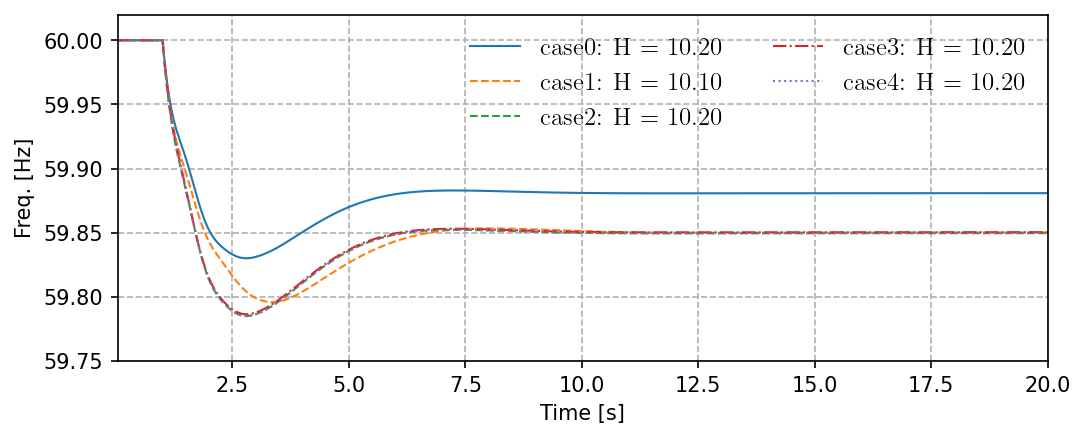

In [8]:
plt.style.use(['ieee', 'default'])
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=150)

a = (0,)
right = 20
ymin, ymax = 59.75, 60.02

s0.TDS.plt.plot(s0.GENROU.omega, a=a,
                right=right,
                ytimes=s0.config.freq,
                ymin=ymin, ymax=ymax,
                grid=True,
                yheader=[f'case0: H = {H0:.2f}'],
                ylabel='Freq. [Hz]',
                ax=ax, fig=fig,
                show=False)

for i, ss, linestyle in zip(range(1, 5),
                            [s1, s2, s3, s4],
                            ['--', '--', '-.', ':']):
    ss.TDS.plt.plot(ss.GENROU.omega, a=a,
                    right=right,
                    ytimes=ss.config.freq,
                    yheader=[f'case{i}: H = {globals()[f"H{i}"]:.2f}'],
                    linestyles=[linestyle],
                    ax=ax, fig=fig,
                    legend_loc='upper right',
                    legend_ncol=2,
                    show=False)